# PA005 - High Value Customer Identification (Insiders)

# Planejanamento da solução (IoT)

## Input - Entrada
    

1. Problema do negócio
    - Selecionar os clientes mais valiosos para integrar um programa de fidelização

2. Conjunto de dados
    - Vendas de um e-commerce online durante o período de um ano

## Output - Saída

1. A indicação das pessoas que farão parte do programa de Insiders
    - Lista: client_id | is_insider |
                10323  | yes/1
                32413  | no/1
                
                
2. Relatório
    1. Quem são as pessoas elegíveis para participar do programa de Insiders ?
    2. Quantos clientes farão parte do grupo?
    3. Quais as principais características desses clientes ?
    4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    5. Qual a expectativa de faturamento desse grupo para os próximos meses ?
    6. Quais as condições para uma pessoa ser elegível ao Insiders ?
    7. Quais as condições para uma pessoa ser removida do Insiders ?
    8. Qual a garantia que o programa Insiders é melhor que o restante da base ?
    9. Quais ações o time de marketing pode realizar para aumentar o faturamento?

## Task - Tarefas

1. Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - O que é ser elegível? O que são clientes de maior "valor"?
    - Faturamento: 
        - Alto ticket médio.
        - Alto LTV (life time value).
        - Baixa Recência.
        - Alto basket size.
        - Baixa probabilidade de Churn.
        - Alta previsão de LTV
        - Alta propensão de compra
        
    - Custo:
        - Baixo taxa de devolução
        
    - Experiência 
        - Média alta de avaliação
        
        
2. Quantos clientes farão parte do grupo?
    - Número total de cliente
    - % do grupo de Insiders
    
3. Quais as principais características desses clientes ?
    - Escrever características do cliente:
        Idade
        Localização
    - Escrever características do consumo:
        Atributos da clusterização
        
4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Faturamento total do ano
    - Faturamento do grupo Insiders
    
5. Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - LTV do grupo Insiders
    - Análise de Cohort 
    
6. Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Definir a periodicidade (1 mes, 3 meses)
    - A pessoa precisa ser similar ou parecido com uma pessoa do grupo
    
7. Quais as condições para uma pessoa ser removida do Insiders ?
    - Definir a periodicidade (1 mes, 3 meses)
    - A pessoa precisa ser dessimilar ou parecido com uma pessoa do grupo
    
8. Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Teste A/B
    - Teste A/B Bayesiano
    - Teste de hipóteses
    
9. Quais ações o time de marketing pode realizar para aumentar o faturamento?
    - Desconto
    - Preferência de compra
    - Frente
    - Visita a empresa

# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import regex as re

from matplotlib import pyplot as plt
from IPython.display import HTML

from sklearn import cluster as c
from sklearn import metrics as m

from plotly import express as px

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


/home/alex/.local/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['re']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Load dataset

In [3]:
df_raw = pd.read_csv('datasets/Ecommerce.csv', encoding='unicode_escape')

#drop extra column
df_raw = df_raw.drop( columns= ['Unnamed: 8'], axis = 1 )

In [4]:
df_raw.sample(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
498096,578510,22659,LUNCH BOX I LOVE LONDON,1,22-Nov-17,1.95,14056.0,United Kingdom
393653,570839,15060B,FAIRY CAKE DESIGN UMBRELLA,4,10-Oct-17,3.75,14911.0,EIRE
348039,567372,85099F,JUMBO BAG STRAWBERRY,10,18-Sep-17,2.08,14191.0,United Kingdom
539215,581439,23346,SPACEBOY BEAKER,1,6-Dec-17,2.46,NaN,United Kingdom
405865,571716,84596B,SMALL DOLLY MIX DESIGN ORANGE BOWL,2,16-Oct-17,0.83,NaN,United Kingdom
508580,579251,22469,HEART OF WICKER SMALL,600,26-Nov-17,1.93,17450.0,United Kingdom
537428,581266,23191,BUNDLE OF 3 RETRO NOTE BOOKS,12,6-Dec-17,1.65,12621.0,Germany
314330,564631,23239,SET OF 4 KNICK KNACK TINS POPPIES,6,24-Aug-17,4.15,17451.0,United Kingdom
174166,551774,47599A,PINK PARTY BAGS,1,2-May-17,2.10,14606.0,United Kingdom
172419,551533,22729,ALARM CLOCK BAKELIKE ORANGE,1,29-Apr-17,3.75,15407.0,United Kingdom


# Descrição dos dados

In [5]:
df1 = df_raw.copy()

## Rename Columns

In [6]:
cols_news = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date','unit_price', 'customer_id', 'country']
df1.columns = cols_news

## Data dimensions

In [7]:
df1.shape

(541909, 8)

## Data types

In [8]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## Data Check NA

In [9]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## Replace NA

In [10]:
df1 = df1.dropna(subset=['description', 'customer_id'])
print('Removed data: {:.2f}%'.format( 1 - (df1.shape[0] / df_raw.shape[0] ) ) )

Removed data: 0.25%


## Change dtypes

In [11]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [12]:
#invoice_date
df1['invoice_date'] =pd.to_datetime(df1['invoice_date'], format = '%d-%b-%y')

#customer_id
df1['customer_id'] = df1['customer_id'].astype(np.int64)

In [13]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## Descriptive Statistics

In [14]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

### Numerical Attributs

In [15]:
#Central Tendecy - média e mediana
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

#Dispersion - desvio, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

#concat
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.0,80995.0,161990.0,12.061303,5.00,248.693064,0.182663,94317.563673
1,unit_price,0.0,38970.0,38970.0,3.460471,1.95,69.315077,452.219019,246924.542988
2,customer_id,12346.0,18287.0,5941.0,15287.690570,15152.00,1713.598197,0.029835,-1.179982


**Skew:** mostra a deformação da sua distribuição em relação a normal

    **Skew positiva:** deformação para a esquerda
    
    **Skew negativa:** deformação para a direita
    
**Kurtosis:** mostra o quão os dados estão concentrados.

    Quanto maior a kurtosis mais dados concentrados, ou seja o pico da curva será muito grande
    
    Quanto menor a kurtosis,mais dispersos estão os dados, ou seja, o pico da curva será menor

#### Numerical Attributs - Investigating

1. quantidade negativa (pode ser devolução)
2. preço unitário igual a zero (pode ser promoção?)


### Categorical Attributs

In [16]:
#stock code
len(cat_attributes.loc[cat_attributes['stock_code'].apply( lambda x: bool(re.search('[^0-9]+', x))), 'stock_code'].drop_duplicates())



886

In [17]:
len(cat_attributes.loc[cat_attributes['invoice_no'].apply( lambda x: bool(re.search('[^0-9]+', x))), 'invoice_no'].drop_duplicates())

3654

# Filtragem de variáveis

In [25]:
df2 = df1.copy()

In [26]:
#===== Numerical Attribuets =====
#unit price > 0
df2 = df2.loc[df2['unit_price'] > 0.010, :]

#stock code != [POST, D, M, DOT,CRUK]
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'M', 'DOT', 'CRUK'])]


df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchase = df2.loc[df2['quantity'] > 0, :]

# Feature Engineering

In [27]:
df3 = df2.copy()

## Feature Creation

In [29]:
#data reference
df_ref = df3.drop( ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'country' ], axis=1).drop_duplicates(ignore_index=True)

In [30]:
#Gross Revenue (Faturamento)
df3['gross_revenue'] = df2_purchase['quantity'] * df2['unit_price']

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


In [29]:
 # data reference
df_ref = df2.drop(['invoice_no', 'stock_code', 'description',
                   'quantity', 'invoice_date', 'unit_price', 
                   'country'], axis=1).drop_duplicates(ignore_index=True)
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


In [30]:
# Gross Revenue ( Faturamento = quantity * price)
df2['gross_revenue'] = df2['quantity'] * df2['unit_price']

#monetary (quanto essa pessoa gastou até o momento)
df_monetary = df2[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left')

# Recency - Last day purchase
df_recency = df2[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

#Frequency
df_freq = df2[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge (df_ref, df_freq, on='customer_id', how='left')





In [31]:
#avg ticket (ticket médio)
df_avg_ticket = df2[['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue': 'avg_ticket'})
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id      0
gross_revenue    0
recency_days     0
invoice_no       0
avg_ticket       0
dtype: int64

In [32]:
df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850,5288.63,302,35,16.950737
1,13047,3079.10,31,18,15.709694
2,12583,7187.34,2,18,28.634821
3,13748,948.25,95,5,33.866071
4,15100,635.10,330,6,105.850000


# EDA (Explory Data Analysis)

In [34]:
df4 = df3.copy()

# Data Preparation

In [35]:
df5 = df4.copy()

# Feature Selection

In [36]:
df6 = df5.copy()

# Hyperparameter Fine-Tunning

In [37]:
X = df6.drop(columns=['customer_id'])

In [24]:
X.head()

,gross_revenue,recency_days,invoice_no
0,5288.63,302,35
1,3079.10,31,18
2,7187.34,2,18
3,948.25,95,5
4,635.10,330,6


##  Within-Cluster Sum of Square (Wss)

In [38]:
clusters = [2, 3, 4, 5, 6, 7]

Text(0.5, 1.0, 'WSS vs K')

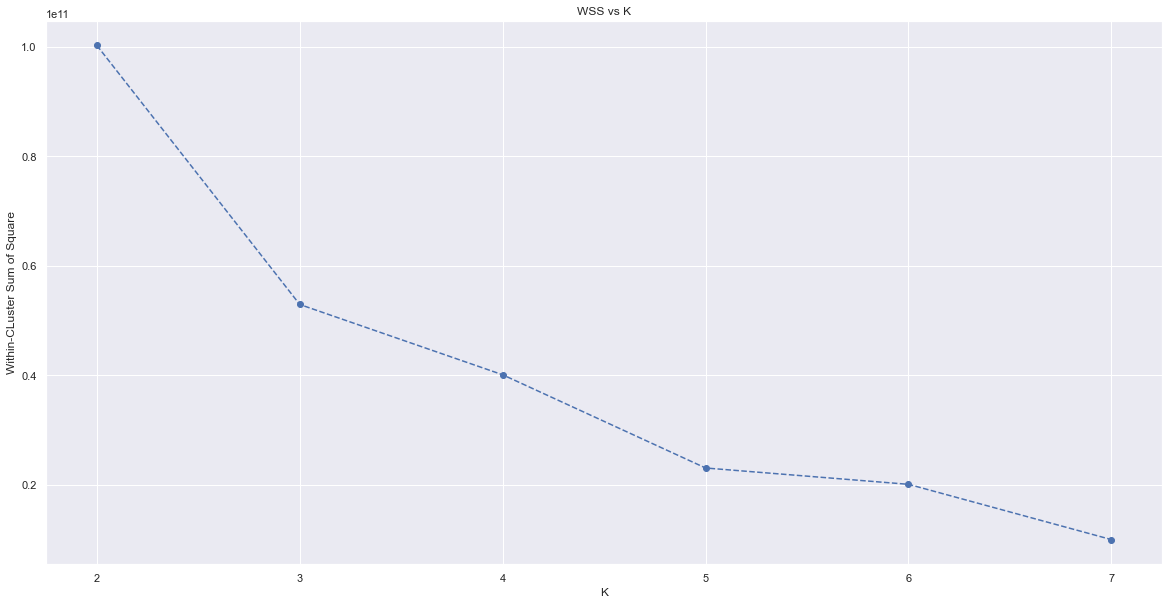

In [39]:
wss = []
for k in clusters:
    #model definition
    kmeans = c.KMeans( init='random', n_clusters = k, n_init=10, max_iter=300, random_state=42)
    
    #model training
    kmeans.fit( X )
    
    #validation
    wss.append(kmeans.inertia_)
    
#plot wss
plt.plot(clusters, wss, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Within-CLuster Sum of Square')
plt.title('WSS vs K')

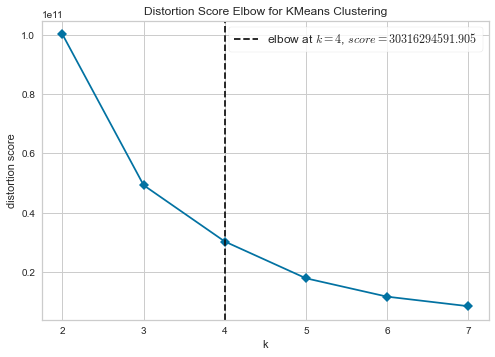

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [40]:
from yellowbrick.cluster import KElbowVisualizer

kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings=False)
kmeans.fit( X )
kmeans.show()

## Silhouette Score

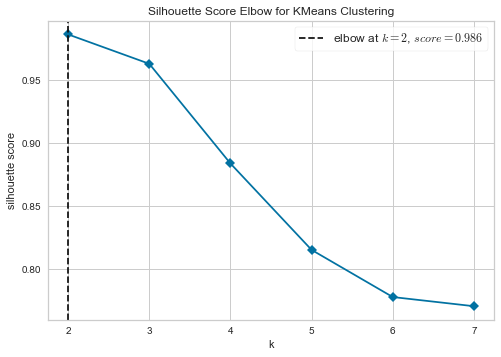

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [41]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timings=False)
kmeans.fit( X )
kmeans.show()

## Sillhouette Analysis

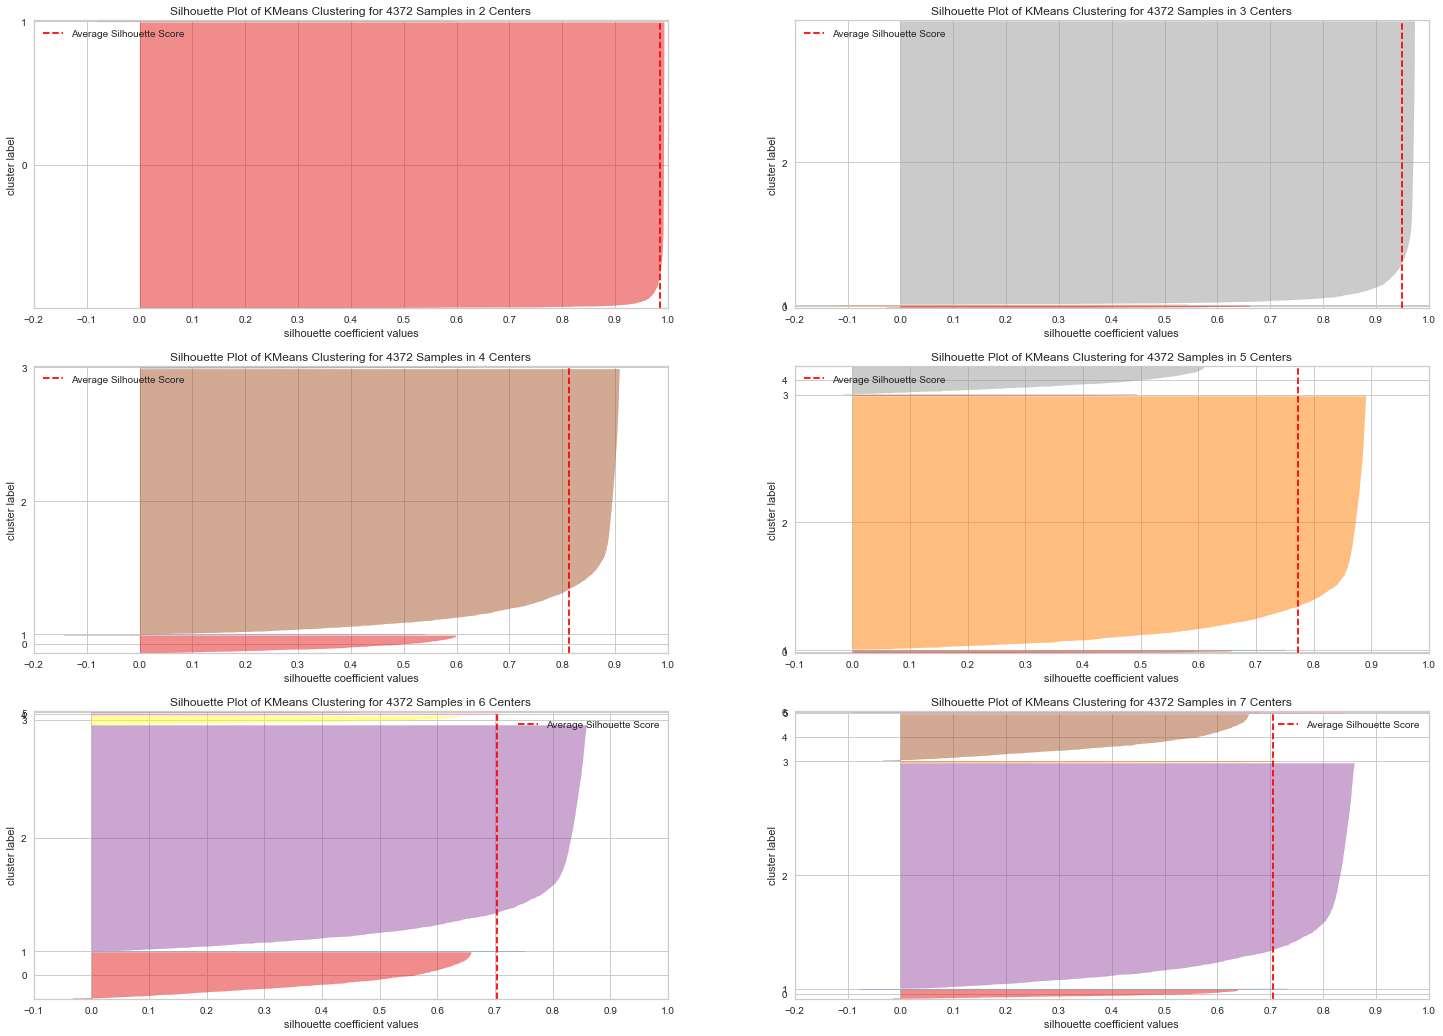

In [50]:
k=2

fig, ax = plt.subplots(3, 2, figsize=(25,18))
for k in clusters:
    km = c.KMeans( n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k, 2)
    visualizer = SilhouetteVisualizer( km, color='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit( X )
    visualizer.finalize()

# Model Training

## K-Means

In [51]:
#model definition
k = 4
kmeans = c.KMeans(init ='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

#model training
kmeans.fit(X)

#clustering
labels = kmeans.labels_

## Cluster Validation

In [52]:
#WSS (Within-cluster sum of square)
print('WSS value: {}'.format( kmeans.inertia_ ) )

# SS (Silhouette Score)
print('SS value: {}'.format( m.silhouette_score( X, labels, metric='euclidean' ) ) ) 

WSS value: 40057070720.55048
SS value: 0.8135844305270019


# Cluster Analysis

In [53]:
df6.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850,5288.63,302,35,16.950737
1,13047,3079.10,31,18,15.709694
2,12583,7187.34,2,18,28.634821
3,13748,948.25,95,5,33.866071
4,15100,635.10,330,6,105.850000


In [54]:
df9 = df6.copy()
df9['clusters'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,clusters
0,17850,5288.63,302,35,16.950737,0
1,13047,3079.10,31,18,15.709694,2
2,12583,7187.34,2,18,28.634821,0
3,13748,948.25,95,5,33.866071,2
4,15100,635.10,330,6,105.850000,2


## Vizualization Inspection

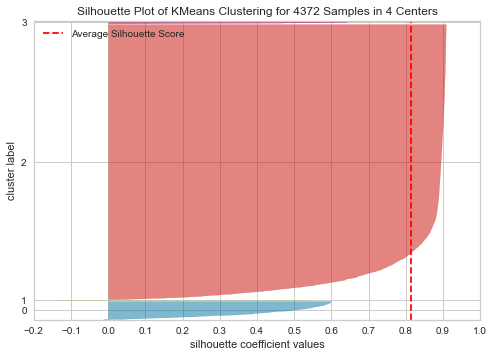

In [55]:
#fig = px.scatter_3d(df9, x='recency_days', y='invoice_no', z='gross_revenue', color='clusters')
#fig.show()

visualizer = SilhouetteVisualizer( kmeans, colors='yellowbrick')
visualizer.fit( X )
visualizer.finalize()

## 2d Plot

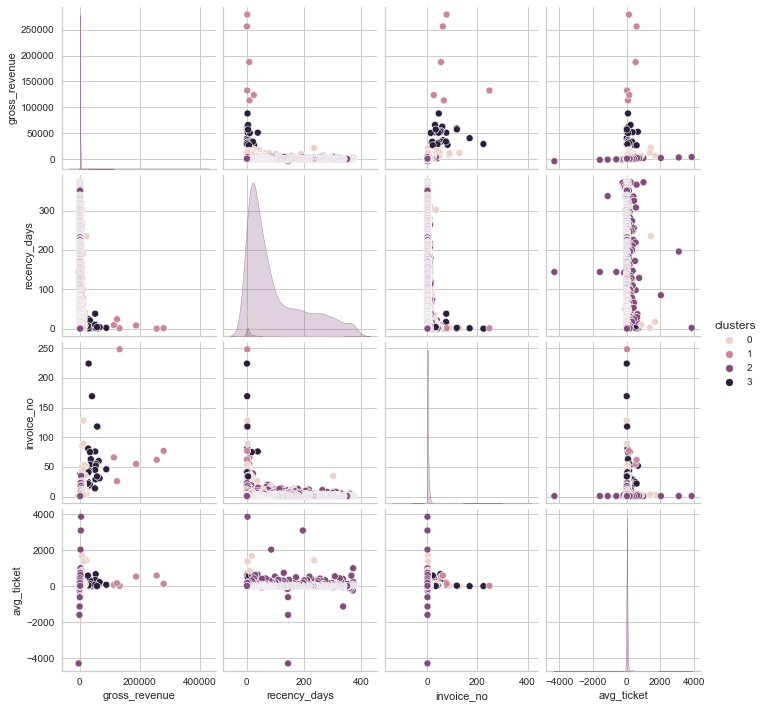

In [57]:
df_viz = df9.drop( columns='customer_id', axis=1)
sns.pairplot( df_viz, hue='clusters')

## UMAP

Machine Learning - Mainfold
PCA - Matrix, Espaço de Distância - Espaço de Hilbert -  9 condições - Colorários

UMAP - t-SNE (2009) - Mainfold - Topologia

In [59]:
import umap.umap_ as umap

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

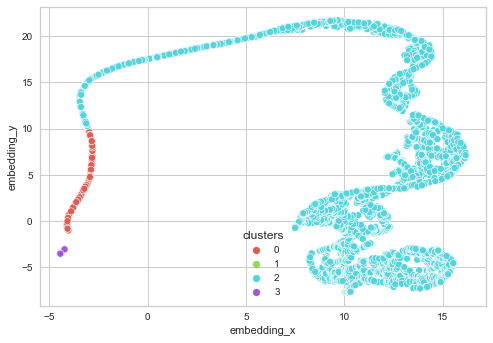

In [66]:
reducer = umap.UMAP( n_neighbors=20, random_state=42)
embedding = reducer.fit_transform( X )

#embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', hue='clusters', 
                palette=sns.color_palette('hls', n_colors=len(df_viz['clusters'].unique() )), data=df_viz)

## Cluster Profile

In [67]:
#Number of customer
df_cluster = df9[['customer_id', 'clusters']].groupby('clusters').count().reset_index()
df_cluster['perc_customer'] = 100 * ( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

#AVG Gross Revenue
df_avg_gross_revenue = df9[['gross_revenue', 'clusters']].groupby('clusters').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='clusters')

#AVG recency days
df_avg_gross_days = df9[['recency_days', 'clusters']].groupby('clusters').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_days, how='inner', on='clusters')

#AVG invoice_no
df_avg_invoice_no = df9[['invoice_no', 'clusters']].groupby('clusters').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_invoice_no, how='inner', on='clusters')

#AVG ticket
df_ticket = df9[['avg_ticket', 'clusters']].groupby('clusters').mean().reset_index()
df_cluster = pd.merge( df_cluster, df_ticket, how='inner', on='clusters')

In [68]:
df_cluster.head()
#gross_revenue = média de gastos
#recency_days = a cada X dias as pessoas estão fazendo compra
#invoice_no = compra em média X produtos


,clusters,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,269,6.152790,8062.273755,20.282528,19.442379,62.479916
1,1,6,0.137237,182181.981667,7.166667,89.000000,253.626345
2,2,4069,93.069533,944.954398,97.006881,3.638978,25.361307
3,3,28,0.640439,42614.387143,6.178571,57.821429,162.862605


### Cluster 01: (Candidato a Insider)

- Número de customers: 6 (0.14% do customers)
- Recência em média: 7 dias
- Compras em média: 89 compras
- Receita em média: $182.182,00 dólares

### Cluster 02:

- Número de customers: 31 (0.71% do customers)
- Recência em média: 14 dias
- Compras em média: 53 compras
- Receita em média: $40.543,52 dólares

### Cluster 03:

- Número de customers: 4335 (99,15% do customers)
- Recência em média: 92 dias
- Compras em média: 5 compras
- Receita em média: $1372,5 dólares